## Analysis of PTNs


**Key Findings:**
- MPS distribution correctly learns a gaussian
- Gradients vanish as horizon increased
- Images dist lower rank than language dist
- Using exp required longer training (50 epochs vs 10)
- Abs is more robust to rank vs exp
- In language modelling, after fitting fully to two examples, all interpolated examples are equally likely. But interpolated sentences are gibberish

**Ideas:**
- (Vanishing gradient) when updating the kth core replace all cores ata distance of 5 away with identity mats
- (Vanishing gradient) orthogonal parameterization of 50% of the cores


**Claims/Theories**:
- MPS does poorly on language because it assigns high probability to linear combinations of examples. But because the examples are discrete, their linear combination is not meaningful. In contrast, assigning high probability to linear combinations of vector representations of images is more acceptable. That's why we can get reasonable NLL values for training on text but when we sample we often run into the interpolated text which ends up looking like gibberish

### Fitting a gaussian distribution with MPS

In [1]:
import torch

class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples: int, d_output: int = 256, horizon: int = 2):
        self.n_samples = n_samples
        self.d_output = d_output
        self.horizon = horizon

        # Use smaller sigma so values rarely exceed [0, 1]
        sigma = 0.15  # tune this (0.1–0.2 usually works well)
        samples = torch.randn(n_samples, horizon) * sigma + 0.5

        # Discretize to [0, d_output - 1]
        samples = (samples * d_output).clamp(0, d_output - 1).round().to(torch.long)

        self.samples = samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        return self.samples[idx]


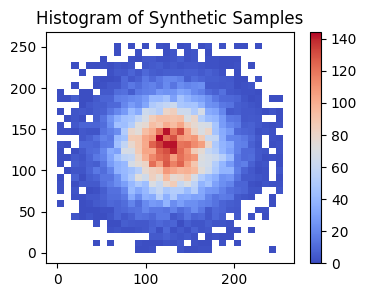

Sample shape: (20000, 8)


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_samples(samples, title="Histogram of Synthetic Samples", x_idx=0, y_idx=1):
    plt.figure(figsize=(4, 3))
    sns.histplot(x=samples[:,x_idx], y=samples[:,y_idx], bins=32, cbar=True, cmap="coolwarm")
    plt.title(title)
    plt.show()


# Hyperparameters
d_model = 1
d_output = 256
horizon = 8
rank = 2
n_samples = 20_000
n_test_samples = 20_000

dataset = SyntheticDataset(n_samples, d_output=d_output, horizon=horizon).samples.numpy()
plot_samples(dataset)
print("Sample shape:", dataset.shape)



In [3]:
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig
model = dists['mps_sigma_lsf'](
    AbstractDisributionHeadConfig(
        d_model=d_model,
        d_output=d_output,
        horizon=horizon,
        rank=rank,
        pos_func="abs",
        mode="direct",
        init_method="ortho",
    )
)
generated_rand = model.generate(torch.ones(n_test_samples, 1))

In [4]:
# Train model

# Hyperparameters
n_epochs = 10
batch_size = 128
lr = 1e-3

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
grads = []
losses = []
for epoch in range(n_epochs):
    train_losses = []
    for i, batch in enumerate(dataloader):
        output = model(torch.ones(batch.size(0), 1), batch)
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))
        train_losses.append(output.loss.item())
    loss_avg = sum(train_losses)/len(train_losses)
    losses.append(loss_avg)
    print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {loss_avg:.2f}")



/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_41505/3639538695.py:19: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))


[Epoch 1/10] Loss: 5.46
[Epoch 2/10] Loss: 5.31
[Epoch 3/10] Loss: 5.18
[Epoch 4/10] Loss: 5.10
[Epoch 5/10] Loss: 5.08
[Epoch 6/10] Loss: 5.07
[Epoch 7/10] Loss: 5.07
[Epoch 8/10] Loss: 5.06
[Epoch 9/10] Loss: 5.06
[Epoch 10/10] Loss: 5.06


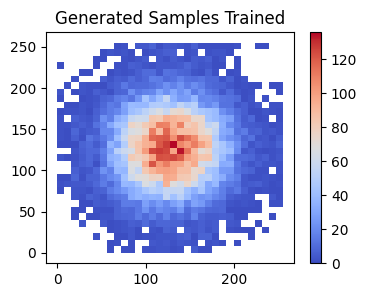

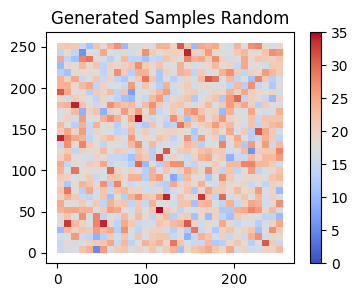

In [5]:
generated_trained = model.generate(torch.ones(n_test_samples, 1))

# Plot generated_trained and generated_rand
plot_samples(generated_trained.numpy(), "Generated Samples Trained")
plot_samples(generated_rand.numpy(), "Generated Samples Random")

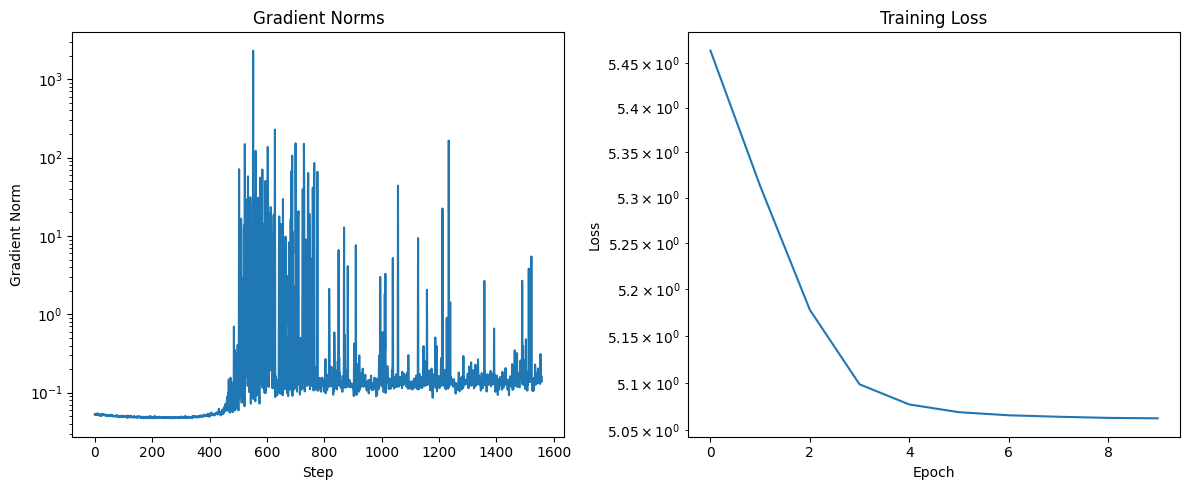

In [6]:
# Plot grads and losses side by side using matplotlib and seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot grads
sns.lineplot(x=range(len(grads)), y=torch.tensor(grads).tolist(), ax=axes[0])
axes[0].set_title("Gradient Norms")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Gradient Norm")
axes[0].set_yscale('log')  # Set log scale before plotting

# Plot losses
sns.lineplot(x=range(len(losses)), y=losses, ax=axes[1])
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_yscale('log')  # Set log scale before plotting

plt.tight_layout()
plt.show()


### Gradient vanishing problem in MPS

In [13]:
# Compare different horizons
import itertools
import torch
from tqdm import tqdm
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig

# Hyperparameters
d_model = 1
d_output = 2
rank = 2
n_epochs = 10
n_samples = 20_000
batch_size = 32
lr = 1e-3
horizons = [8, 32]
modes = ["direct", "residual"]
pos_funcs = ["abs", "exp", "sigmoid"]
init_methods = ["ortho", "randn"]
model_names = ['mps_sigma_lsf']

records = []  

def flatten(lst: list[torch.Tensor]) -> torch.Tensor:
    # Filter out None values
    lst = [l for l in lst if l is not None]
    return torch.cat([l.detach().flatten() for l in lst])

for mode, horizon, pos_func, init_method, md in tqdm(itertools.product(modes, horizons, pos_funcs, init_methods, model_names)):
    dataset = SyntheticDataset(n_samples, d_output=d_output, horizon=horizon).samples.numpy()
    model = dists[md](
        AbstractDisributionHeadConfig(
            d_model=d_model,
            d_output=d_output,
            horizon=horizon,
            rank=rank,
            mode=mode,
            pos_func=pos_func,
            init_method=init_method,
        )
    )

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        train_losses = []
        for i, batch in enumerate(dataloader):
            n = epoch * len(dataloader) + i  # iteration number
            output = model(torch.ones(batch.size(0), 1), batch)
            optimizer.zero_grad()
            output.loss.backward()
            rec = {
                "mode": mode,
                "horizon": horizon, 
                "init_method": init_method,
                "pos_func": pos_func,
                "iter": n, 
                "grad_norm": torch.nn.utils.clip_grad_norm(model.parameters(), 1.0).item(),
                "param_norm": torch.nn.utils.parameters_to_vector(model.parameters()).norm().item(),
                "loss": output.loss.item()
            }
            records.append(rec)
            optimizer.step()
            train_losses.append(output.loss.item())
        loss_avg = sum(train_losses)/len(train_losses)
        records.append({ **rec, "loss_avg": loss_avg })
        # print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {loss_avg:.2f}")



/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_37870/80504003.py:58: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  "grad_norm": torch.nn.utils.clip_grad_norm(model.parameters(), 1.0).item(),


[Epoch 1/10] Loss: 0.35
[Epoch 2/10] Loss: 0.19
[Epoch 3/10] Loss: 0.19
[Epoch 4/10] Loss: 0.19
[Epoch 5/10] Loss: 0.19
[Epoch 6/10] Loss: 0.19
[Epoch 7/10] Loss: 0.19
[Epoch 8/10] Loss: 0.19
[Epoch 9/10] Loss: 0.19
[Epoch 10/10] Loss: 0.19
[Epoch 1/10] Loss: 0.50
[Epoch 2/10] Loss: 0.22
[Epoch 3/10] Loss: 0.19
[Epoch 4/10] Loss: 0.19
[Epoch 5/10] Loss: 0.19
[Epoch 6/10] Loss: 0.19
[Epoch 7/10] Loss: 0.19
[Epoch 8/10] Loss: 0.19
[Epoch 9/10] Loss: 0.19
[Epoch 10/10] Loss: 0.19
[Epoch 1/10] Loss: 0.39
[Epoch 2/10] Loss: 0.22
[Epoch 3/10] Loss: 0.20
[Epoch 4/10] Loss: 0.19
[Epoch 5/10] Loss: 0.19
[Epoch 6/10] Loss: 0.19
[Epoch 7/10] Loss: 0.19
[Epoch 8/10] Loss: 0.19
[Epoch 9/10] Loss: 0.19
[Epoch 10/10] Loss: 0.19
[Epoch 1/10] Loss: 0.70
[Epoch 2/10] Loss: 0.25
[Epoch 3/10] Loss: 0.20
[Epoch 4/10] Loss: 0.19
[Epoch 5/10] Loss: 0.19
[Epoch 6/10] Loss: 0.19
[Epoch 7/10] Loss: 0.19
[Epoch 8/10] Loss: 0.19
[Epoch 9/10] Loss: 0.19
[Epoch 10/10] Loss: 0.19
[Epoch 1/10] Loss: 0.53
[Epoch 2/10]

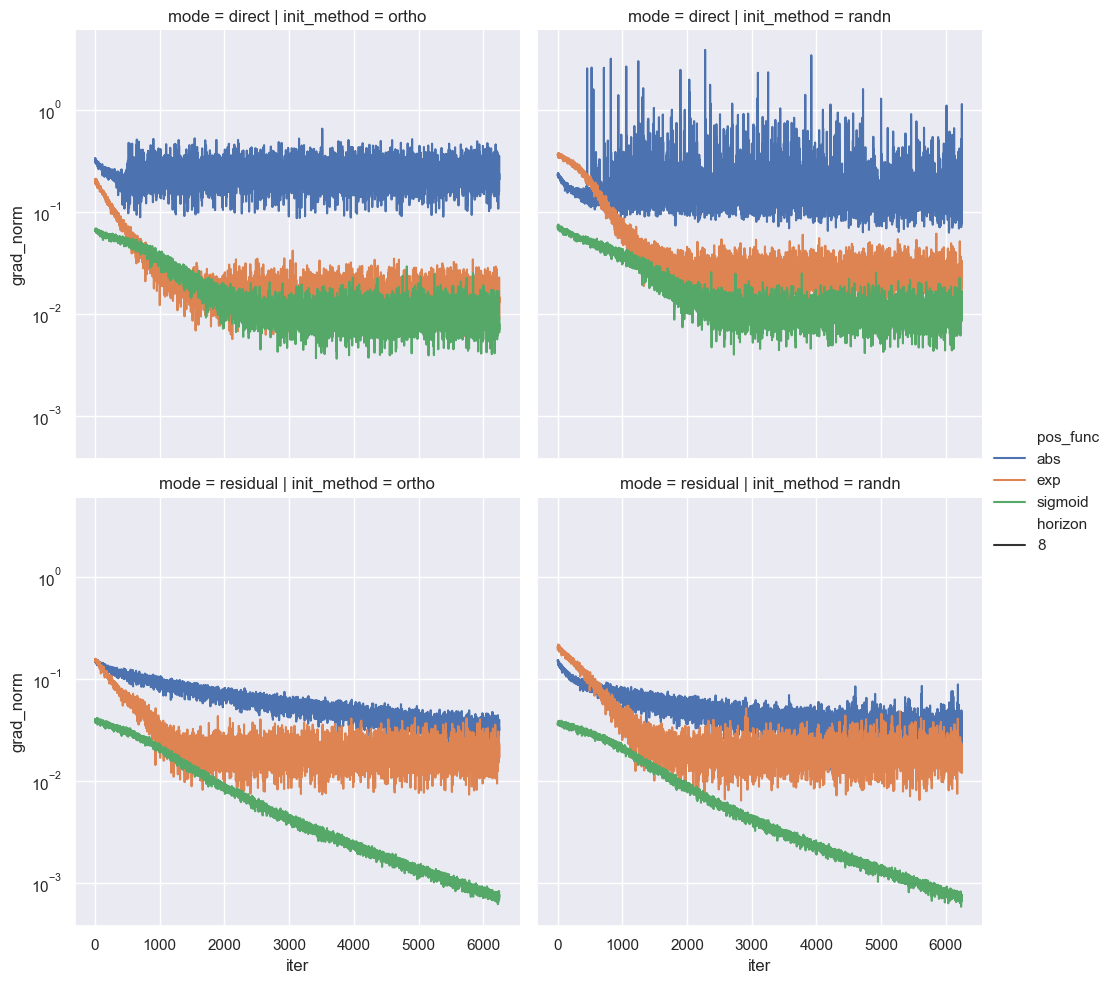

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert records_grads to a DataFrame for easy plotting
df_grads = pd.DataFrame(records)
sns.set_theme()

# Use a different color palette for hues
sns.relplot(
    data=df_grads,
    x="iter",
    y="grad_norm",
    kind="line",
    hue="pos_func",
    style="horizon",
    col="init_method",
    row="mode",
)
plt.yscale("log")  # Apply log scale to y-axis (may log scale)


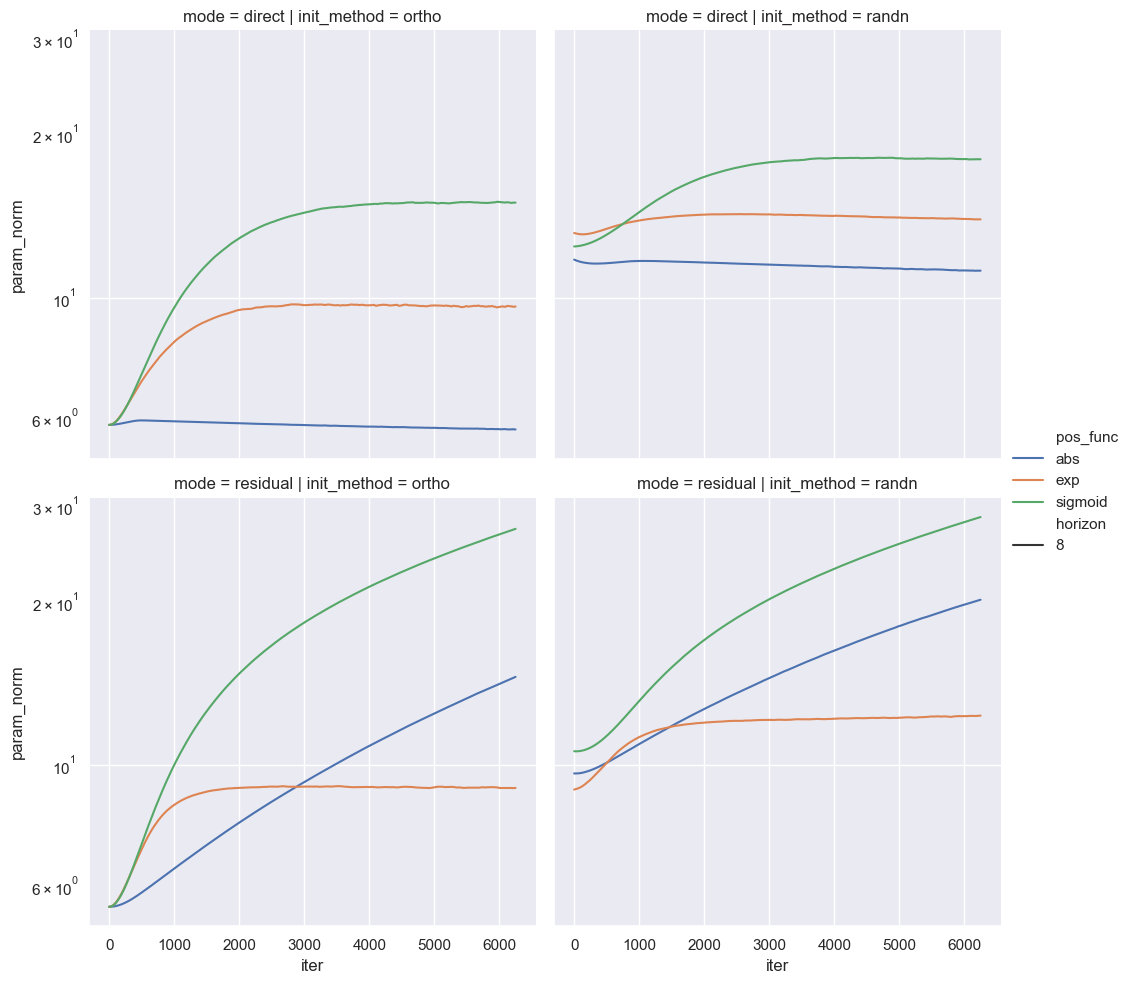

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert records_grads to a DataFrame for easy plotting
df_grads = pd.DataFrame(records)
sns.set_theme()

# Use a different color palette for hues
sns.relplot(
    data=df_grads,
    x="iter",
    y="param_norm",
    kind="line",
    hue="pos_func",
    style="horizon",
    col="init_method",
    row="mode",
)
plt.yscale("log")  # Apply log scale to y-axis (may log scale)


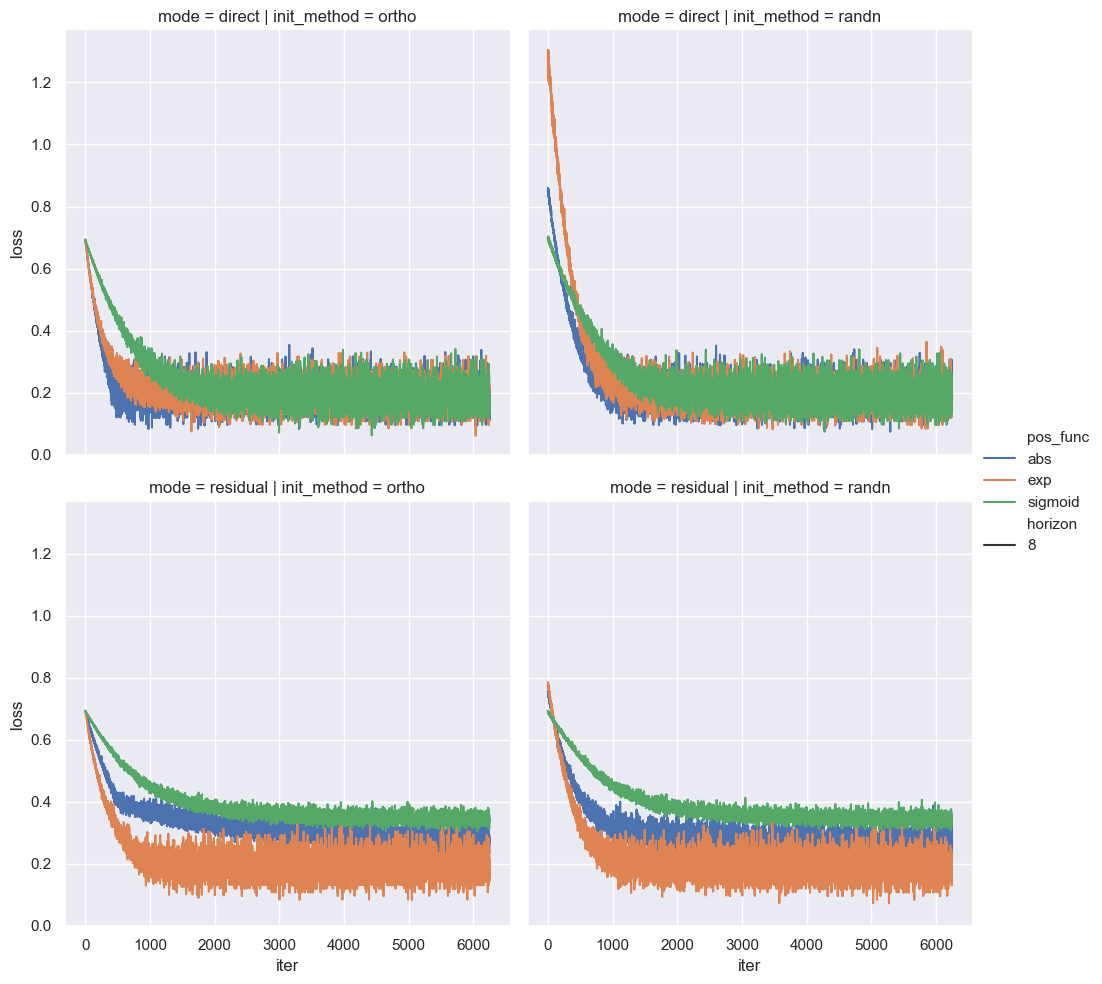

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert records_grads to a DataFrame for easy plotting
df_grads = pd.DataFrame(records)
sns.set_theme()

# Use a different color palette for hues
sns.relplot(
    data=df_grads,
    x="iter",
    y="loss",
    kind="line",
    hue="pos_func",
    style="horizon",
    col="init_method",
    row="mode",
)


### Dataset complexity

Here we compare mnist with language

In [3]:
# Helper functions

import torch
import torchvision
from torchvision import transforms
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
import certifi
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

os.environ["SSL_CERT_FILE"] = certifi.where()


class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        tokenizer,
        seq_len=256,
        max_samples=None,
        file_path="dataloaders/data/tinyshakespeare.txt",
    ):
        self.tokenizer = tokenizer
        self.seq_len = seq_len

        # Read Shakespeare text
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Tokenize the entire text
        tokens = self.tokenizer.encode(text)

        # Limit samples if specified
        if max_samples:
            tokens = tokens[: max_samples * seq_len]

        # Create sequences
        self.sequences = []
        for i in range(0, len(tokens) - seq_len, seq_len):
            seq = tokens[i : i + seq_len]
            if len(seq) == seq_len:
                self.sequences.append(seq)
        # for i in range(0, len(tokens) - seq_len, seq_len // 2):  # 50% overlap
        #     seq = tokens[i : i + seq_len]
        #     if len(seq) == seq_len:
        #         self.sequences.append(seq)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return {"input_ids": torch.tensor(seq, dtype=torch.long)}


class BPETokenizerWrapper:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.get_vocab_size()
        self.eos_token = "</s>"
        self.pad_token = "<pad>"
        self.eos_token_id = tokenizer.token_to_id(self.eos_token)
        self.pad_token_id = tokenizer.token_to_id(self.pad_token)

    def __len__(self):
        return self.vocab_size

    def encode(self, text, **kwargs):
        return self.tokenizer.encode(text).ids

    def decode(self, ids, skip_special_tokens=True):
        return self.tokenizer.decode(ids)

    def get_vocab_size(self):
        return self.vocab_size

# def get_tokenizer(corpus_path, bit_size, n_bits_per_token):
#     from tokenizers import Tokenizer
#     from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers

#     # Initialize
#     tokenizer = Tokenizer(models.BPE())
#     tokenizer.normalizer = normalizers.NFKC()
#     tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

#     # Setup trainer
#     trainer = trainers.BpeTrainer(
#         vocab_size=bit_size**n_bits_per_token,
#         special_tokens=["<pad>", "<unk>", "<s>", "</s>"],
#     )

#     assert os.path.exists(corpus_path), f"File not found: {corpus_path}"

#     # Train
#     print("Vocab size before training:", tokenizer.get_vocab_size())
#     tokenizer.train([corpus_path], trainer)

#     # # Save and verify
#     # tokenizer.save("bpe_tokenizer.json")
#     print("Vocab size after training:", tokenizer.get_vocab_size())

#     return BPETokenizerWrapper(tokenizer)


def get_tokenizer(corpus_path, bit_size, n_bits_per_token):
    # You seem to want a specific vocab size tied to your later bin-coding:
    vocab_size = bit_size ** n_bits_per_token  # e.g., 2**8 = 256, 2**16 = 65536

    tok = Tokenizer(models.BPE(unk_token="<unk>"))
    tok.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
    tok.decoder = decoders.ByteLevel()
    tok.post_processor = processors.ByteLevel(trim_offsets=False)

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
        special_tokens=["<pad>", "<unk>", "<s>", "</s>"],
    )

    tok.train([corpus_path], trainer)
    return BPETokenizerWrapper(tok)


def get_mnist(n_samples: int = 1000, seq_len: int = 1000, data_dir: str = "./data", scale=None):
    """Create MNIST data loaders with binary thresholding."""
    transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).long()])
    if scale is not None:
        transform = transforms.Compose(
            [
                transforms.Resize(
                    (scale, scale)
                ),  # rescale from 28x28 -> (scale, scale)
                transforms.ToTensor(),
                lambda x: (x > 0.5).long(),  # binarize
            ]
        )
    # return torch.randint(0, 2, (n_samples, seq_len)).float()
    train_set = torchvision.datasets.MNIST(
        data_dir, train=True, transform=transform, download=True
    )
    # Give single tensor of shape (n_samples, seq_len)
    return torch.stack([t[0].reshape(-1) for t in train_set])[:n_samples, :seq_len].float()


def dec2bin(x, bits):
    # mask = 2 ** torch.arange(bits).to(x.device, x.dtype)
    dv, dt = x.device, x.dtype
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(dv, dt)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).to(dt)

def get_shakespeare(
    n_samples: int = 1000, 
    seq_len: int = 1000, 
    dataset_path: str = "../data/shakespeare/main.txt", 
    bit_size: int = 2, 
    n_bits_per_token: int = 8
):
    # return torch.randint(0, 2, (n_samples, seq_len)).float()
    tokenizer = get_tokenizer(corpus_path="../data/shakespeare/main.txt", bit_size=bit_size, n_bits_per_token=n_bits_per_token)
    dataset = ShakespeareDataset(tokenizer, seq_len=seq_len, max_samples=n_samples, file_path=dataset_path)
    dataset = torch.stack([t["input_ids"] for t in dataset])[:n_samples]  # (n_samples, seq_len)
    dataset = dec2bin(dataset, n_bits_per_token)
    return dataset.reshape(n_samples, -1)[:, :seq_len].float()


def standardize(dataset: torch.Tensor):
    # Shape: (n_samples, seq_len)
    return (dataset - dataset.mean(dim=0))


# dataset_mnist = get_mnist()
# dataset_shakespeare = get_shakespeare()
# for name, dataset in {"mnist": dataset_mnist, "shakespeare": dataset_shakespeare}.items():
#     print(f"{name} dataset shape: {dataset.shape}")


# datasets = {
#     "mnist": get_mnist(),
#     "shakespeare::2::4": get_shakespeare(bit_size=2, n_bits_per_token=4),
#     "shakespeare::2::8": get_shakespeare(bit_size=2, n_bits_per_token=8),
#     "shakespeare::2::16": get_shakespeare(bit_size=2, n_bits_per_token=16),
# }


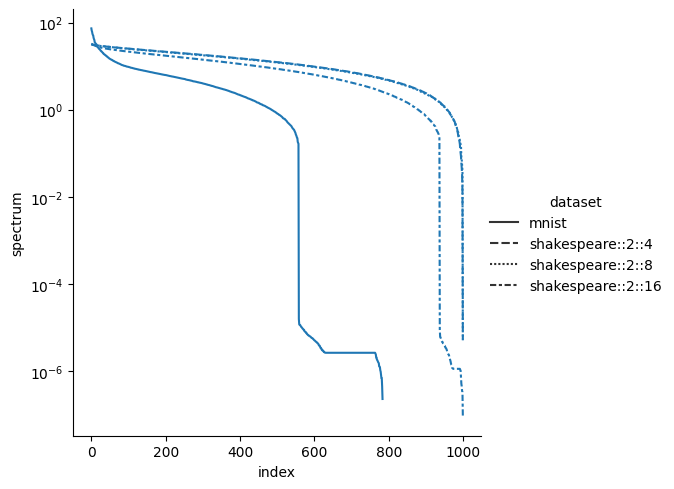

In [47]:
# Hyperparameters
n_samples = 10_000
seq_len = 1000

cols = []
for name, dataset in datasets.items():
    _, s, _ = torch.svd(standardize(dataset))
    cols.append({"dataset": name, "spectrum": s, "index": range(len(s))})

dfs = [pd.DataFrame(col) for col in cols]
df = pd.concat(dfs)

# Use seaborn but assign different markers per dataset using style=
sns.relplot(
    data=df,
    x="index",
    y="spectrum",
    kind="line",
    style="dataset",   # Add marker differentiation by dataset
)
plt.yscale("log")  # Apply log scale to y-axis (may log scale)


### Fitting shakespeare with MPS

In [4]:
# Helpers
import torch
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig

def dec2bin(x, bits):
    # mask = 2 ** torch.arange(bits).to(x.device, x.dtype)
    dv, dt = x.device, x.dtype
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(dv, dt)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).to(dt)

def bin2dec(b, bits):
    # note data type is important here and converted from int to float
    assert (
        b.size(-1) == bits
    ), f"Binary tensor last dimension must be of size {bits}"
    dv, dt = b.device, b.dtype
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(dv, dt)
    return torch.sum(mask * b, -1).to(dt)

In [5]:
# Hyperparameters
n_samples = 2
seq_len = 2
batch_size = 32
# bit_size = 512
# n_bits_per_token = 1
bit_size = 2
n_bits_per_token = 9
file_path = "../data/shakespeare/main.txt"

tokenizer = get_tokenizer(corpus_path=file_path, bit_size=bit_size, n_bits_per_token=n_bits_per_token)
dataset = ShakespeareDataset(tokenizer, seq_len=seq_len, max_samples=n_samples+1, file_path=file_path)
print('Num. Tokens:', tokenizer.get_vocab_size())




Num. Tokens: 512


In [6]:
# Visualize 
for i in range(min(10, len(dataset))):
    x_str = tokenizer.decode(dataset[i]['input_ids'].tolist())
    print(f"{repr(x_str)} (len: {len(dataset[i]['input_ids'])})")

print(f"\n\nDataset:\nNum. Samples: {len(dataset)}\nShape: {dataset[0]['input_ids'].shape}\n")


' Fir' (len: 2)
'st C' (len: 2)


Dataset:
Num. Samples: 2
Shape: torch.Size([2])



In [7]:
# Hyperparameters
d_model = 1
d_output = bit_size
horizon = seq_len * n_bits_per_token
rank = 4

model = dists['mps_sigma_lsf'](
    AbstractDisributionHeadConfig(
        d_model=d_model,
        d_output=d_output,
        horizon=horizon,
        rank=rank,
        pos_func="abs",
        mode="direct",
        init_method="ortho",
    )
)

# Random model will be used later for comparison
model_rand = dists['mps_sigma_lsf'](
    AbstractDisributionHeadConfig(
        d_model=d_model,
        d_output=d_output,
        horizon=horizon,
        rank=rank,
        pos_func="abs",
        mode="direct",
        init_method="ortho",
    )
)

In [8]:
# Train model

# Hyperparameters
n_epochs = 200
batch_size = 128
lr = 5e-3

def collate_fn(batch):
    return {
        'input_ids': torch.stack([dec2bin(t['input_ids'], n_bits_per_token).reshape(-1) for t in batch])
    }

def generate_sample(model, tokenizer):
    x = model.generate(torch.ones(1, 1))
    # x = bin2dec(xb.reshape(1, -1, n_bits_per_token), n_bits_per_token)
    x_str = tokenizer.decode(x[0].tolist())
    return x_str


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
grads = []
losses = []
print(f"\n\nTraining model...")
print(f"Num batches: {len(dataloader)}")
for epoch in range(n_epochs):
    train_losses = []
    for i, batch in enumerate(dataloader):
        x = batch['input_ids']
        print(f"x: {x.shape}")
        output = model(torch.ones(x.size(0), 1), x)
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))
        train_losses.append(output.loss.item())
    loss_avg = sum(train_losses)/len(train_losses)
    losses.append(loss_avg)

    # Generate sample
    # # Decimal
    # y = model.generate(torch.ones(1, 1))
    # y_str = tokenizer.decode(y[0].tolist())
    # d = (x.float() - y.float()).norm().item()

    # Binary
    output_generate = model.generate(torch.ones(1, 1), do_sample=True)
    yb = output_generate.y
    y = bin2dec(yb.reshape(1, -1, n_bits_per_token), n_bits_per_token)
    y_str = tokenizer.decode(y[0].tolist())
    p0 = output_generate.p_tilde[0,1].detach().tolist()
    print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {loss_avg:.2f} | p[1]: {', '.join(f'{p:.2f}' for p in p0)} | {repr(y_str)}")




Training model...
Num batches: 1
x: torch.Size([2, 18])
[Epoch 1/200] Loss: 0.69 | p[1]: 1.01, 0.99 | 'herc'
x: torch.Size([2, 18])
[Epoch 2/200] Loss: 0.69 | p[1]: 1.02, 0.98 | '�2'
x: torch.Size([2, 18])
[Epoch 3/200] Loss: 0.68 | p[1]: 1.03, 0.97 | '\x03-'
x: torch.Size([2, 18])
[Epoch 4/200] Loss: 0.67 | p[1]: 1.04, 0.96 | '�im'
x: torch.Size([2, 18])
[Epoch 5/200] Loss: 0.67 | p[1]: 1.05, 0.95 | '\x05 H'
x: torch.Size([2, 18])


/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_45046/1135387701.py:35: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))


[Epoch 6/200] Loss: 0.66 | p[1]: 1.06, 0.94 | '��'
x: torch.Size([2, 18])
[Epoch 7/200] Loss: 0.65 | p[1]: 1.07, 0.93 | '�au'
x: torch.Size([2, 18])
[Epoch 8/200] Loss: 0.65 | p[1]: 1.08, 0.92 | ' oni'
x: torch.Size([2, 18])
[Epoch 9/200] Loss: 0.64 | p[1]: 1.09, 0.91 | 'on�'
x: torch.Size([2, 18])
[Epoch 10/200] Loss: 0.64 | p[1]: 1.10, 0.90 | ' shall�'
x: torch.Size([2, 18])
[Epoch 11/200] Loss: 0.63 | p[1]: 1.11, 0.89 | '4 to'
x: torch.Size([2, 18])
[Epoch 12/200] Loss: 0.62 | p[1]: 1.12, 0.88 | ' h with'
x: torch.Size([2, 18])
[Epoch 13/200] Loss: 0.62 | p[1]: 1.13, 0.87 | ' wp'
x: torch.Size([2, 18])
[Epoch 14/200] Loss: 0.61 | p[1]: 1.14, 0.86 | '\\{'
x: torch.Size([2, 18])
[Epoch 15/200] Loss: 0.61 | p[1]: 1.15, 0.85 | 'AR A'
x: torch.Size([2, 18])
[Epoch 16/200] Loss: 0.60 | p[1]: 1.16, 0.84 | 'as u'
x: torch.Size([2, 18])
[Epoch 17/200] Loss: 0.59 | p[1]: 1.17, 0.83 | '\x18 lo'
x: torch.Size([2, 18])
[Epoch 18/200] Loss: 0.59 | p[1]: 1.18, 0.82 | ' B will'
x: torch.Size([2, 18

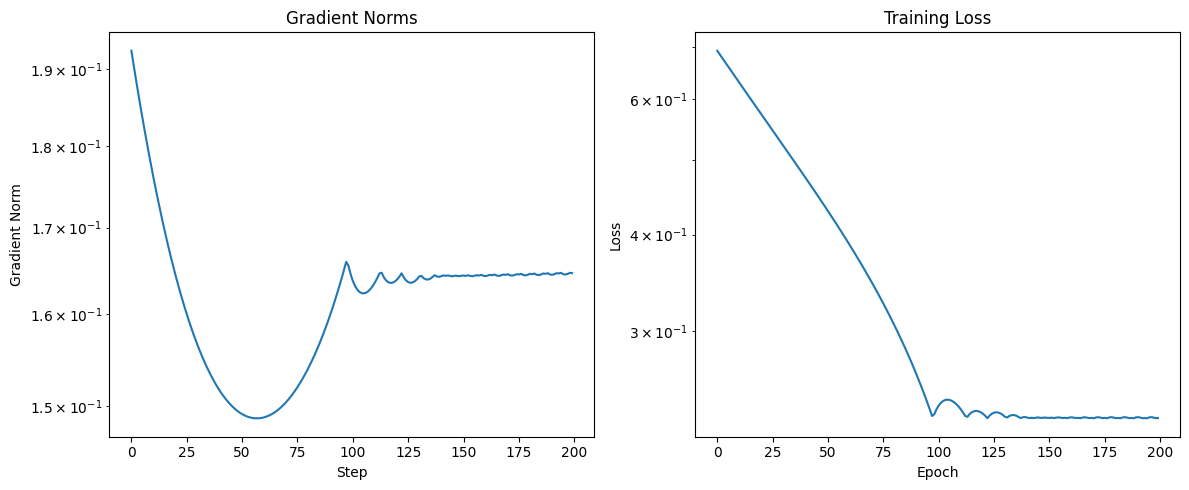

In [9]:
# Plot grads and losses side by side using matplotlib and seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot grads
sns.lineplot(x=range(len(grads)), y=torch.tensor(grads).tolist(), ax=axes[0])
axes[0].set_title("Gradient Norms")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Gradient Norm")
axes[0].set_yscale('log')  # Set log scale before plotting

# Plot losses
sns.lineplot(x=range(len(losses)), y=losses, ax=axes[1])
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_yscale('log')  # Set log scale before plotting

plt.tight_layout()
plt.show()

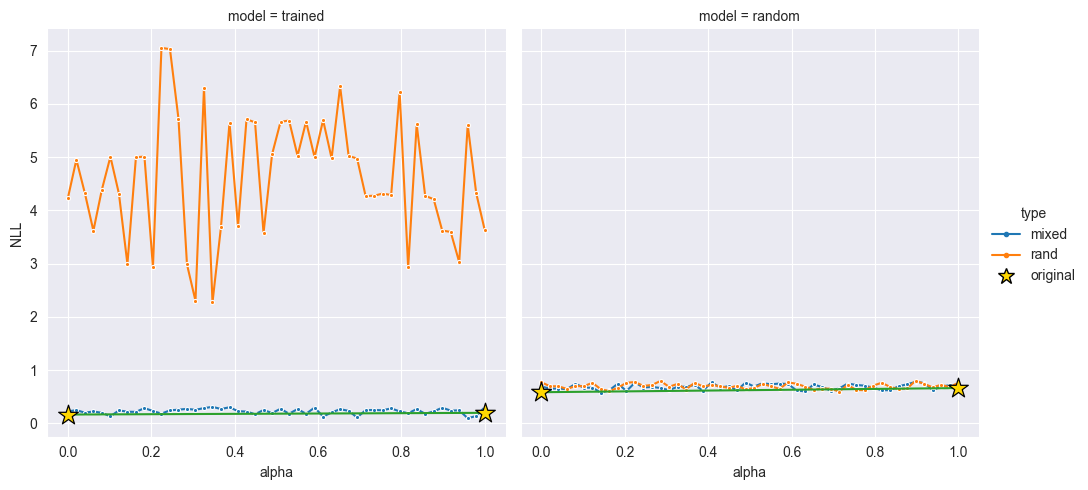

In [10]:
# Plot likelihoods of all interpolated sentences
sns.set_style("darkgrid")

def merge_vecs(v1, v2, alpha):
    m = torch.rand(len(v1)) < alpha
    return m * v1 + (1 - m.float()) * v2

xa = dataset[0]['input_ids']
xb = dataset[1]['input_ids']

# convert to binary
xa = dec2bin(xa, n_bits_per_token).reshape(-1).to(torch.long)
xb = dec2bin(xb, n_bits_per_token).reshape(-1).to(torch.long)

# Add interpolated xs
xs = []
for alpha in torch.linspace(0, 1, 50):
    x = merge_vecs(xa.float(), xb.float(), alpha).to(torch.long)
    xs.append({'alpha': alpha.item(), 'x': x, 'type': 'mixed'})

# Add random xs
for alpha in torch.linspace(0, 1, 50):
    x = torch.randint(0, 2, (1, seq_len * n_bits_per_token))
    xs.append({'alpha': alpha.item(), 'x': x, 'type': 'rand'})

# Add original xs with special marker type
xs.append({'alpha': 0, 'x': xa, 'type': 'original'})
xs.append({'alpha': 1, 'x': xb, 'type': 'original'})


# Compute NLLs
records = []
for x_dct in xs:
    output = model(torch.ones(1, 1), x_dct['x'].reshape(1, -1))
    records.append({**x_dct, 'nll': output.loss.item(), 'model': 'trained'})
    output_rand = model_rand(torch.ones(1, 1), x_dct['x'].reshape(1, -1))
    records.append({**x_dct, 'nll': output_rand.loss.item(), 'model': 'random'})


# Plot all lines first (no markers)
df = pd.DataFrame(records)

df['NLL'] = df['nll'] + torch.randn(len(df)).numpy() * 0.05
markers = {"mixed": ".", "rand": ".", "original": "*"}

g = sns.relplot(
    data=df,
    x="alpha",
    y="NLL",
    hue="type",
    style="type",
    col="model",
    kind="line",
    markers=markers,
    dashes=False,
)

# Overlay big stars for originals in the correct facet
for ax, md in zip(g.axes.flat, g.col_names):
    d = df[(df["type"] == "original") & (df["model"] == md)]
    ax.scatter(
        d["alpha"], d["NLL"],
        marker="*", s=220, zorder=10,
        facecolor="#FFD700", edgecolor="black", linewidth=0.9,
        label="original"
    )

# Fix legend
if g._legend:
    for text, handle in zip(g._legend.texts, g._legend.legend_handles):
        if text.get_text() == "original":
            handle.set_marker("*")
            handle.set_markersize(12)
            handle.set_markerfacecolor("#FFD700")
            handle.set_markeredgecolor("black")
            handle.set_linestyle("")

# # Make y-axis log scale
# for ax in g.axes.flat:
#     ax.set_yscale('log')

# plt.show()


#### Categorical MPS (len=2)

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class RandomIndexDataset(Dataset):
    def __init__(self, vocab_size, seq_length, num_samples):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        input_ids = torch.randint(low=0, high=self.vocab_size, size=(self.seq_length,))
        # For categorical tasks, the "target" might just be the input itself or next token, adapt if needed:
        target = input_ids.clone()
        return {'input_ids': input_ids, 'labels': target}


class RandomDiagonalDataset(Dataset):
    def __init__(self, vocab_size, seq_length, num_samples):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.num_samples = num_samples
        # store sampled values for each sample, later used for diagonal
        self.samples = torch.randint(low=0, high=self.vocab_size, size=(self.num_samples,))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Each element in the sequence is identical, e.g., [0,0] or [1,1], etc.
        value = self.samples[idx].item()
        input_ids = torch.full((self.seq_length,), fill_value=value, dtype=torch.long)
        target = input_ids.clone()
        return {'input_ids': input_ids, 'labels': target}

# Example setup for categorical MPS toy problem:
vocab_size = 10
seq_length = 2
num_samples = 2

dataset = RandomDiagonalDataset(vocab_size, seq_length, num_samples)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Show first few samples
for s in dataset:
    print(s)


{'input_ids': tensor([8, 8]), 'labels': tensor([8, 8])}
{'input_ids': tensor([8, 8]), 'labels': tensor([8, 8])}


In [15]:
# Set random seed for reproducibility
import torch
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig
seed = 28

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Hyperparameters
d_model = 1
d_output = 8
horizon = 2
rank = 2
n_epochs = 1000
batch_size = 128
num_samples = 2
lr = 1e-3

model = dists['mps_sigma_lsf'](
    AbstractDisributionHeadConfig(
        d_model=d_model,
        d_output=d_output,
        horizon=horizon,
        rank=rank,
        pos_func="abs",
        mode="direct",
        init_method="ortho",
        # rank_dropout=0.1,
    )
)

model_rand = dists['mps_sigma_lsf'](
    AbstractDisributionHeadConfig(
        d_model=d_model,
        d_output=d_output,
        horizon=horizon,
        rank=rank,
        pos_func="abs",
        mode="direct",
        init_method="ortho",
    )
)

dataset = RandomDiagonalDataset(d_output, seq_length, num_samples)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
grads = []
losses = []
print(f"\n\nTraining model...")
print(f"Num batches: {len(dataloader)}")
for epoch in range(n_epochs):
    train_losses = []
    for i, batch in enumerate(dataloader):
        x = batch['input_ids']
        # print(f"x: {x.shape}")
        output = model(torch.ones(x.size(0), 1), x)
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))
        train_losses.append(output.loss.item())
    loss_avg = sum(train_losses)/len(train_losses)
    losses.append(loss_avg)
    print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {loss_avg:.2f}")




Training model...
Num batches: 1
[Epoch 1/1000] Loss: 2.08
[Epoch 2/1000] Loss: 2.08
[Epoch 3/1000] Loss: 2.07
[Epoch 4/1000] Loss: 2.07
[Epoch 5/1000] Loss: 2.07
[Epoch 6/1000] Loss: 2.06
[Epoch 7/1000] Loss: 2.06
[Epoch 8/1000] Loss: 2.06
[Epoch 9/1000] Loss: 2.06
[Epoch 10/1000] Loss: 2.05
[Epoch 11/1000] Loss: 2.05
[Epoch 12/1000] Loss: 2.05
[Epoch 13/1000] Loss: 2.04
[Epoch 14/1000] Loss: 2.04
[Epoch 15/1000] Loss: 2.04
[Epoch 16/1000] Loss: 2.03
[Epoch 17/1000] Loss: 2.03
[Epoch 18/1000] Loss: 2.03
[Epoch 19/1000] Loss: 2.03
[Epoch 20/1000] Loss: 2.02
[Epoch 21/1000] Loss: 2.02
[Epoch 22/1000] Loss: 2.02
[Epoch 23/1000] Loss: 2.01
[Epoch 24/1000] Loss: 2.01
[Epoch 25/1000] Loss: 2.01
[Epoch 26/1000] Loss: 2.01
[Epoch 27/1000] Loss: 2.00
[Epoch 28/1000] Loss: 2.00
[Epoch 29/1000] Loss: 2.00
[Epoch 30/1000] Loss: 1.99
[Epoch 31/1000] Loss: 1.99
[Epoch 32/1000] Loss: 1.99
[Epoch 33/1000] Loss: 1.99
[Epoch 34/1000] Loss: 1.98
[Epoch 35/1000] Loss: 1.98
[Epoch 36/1000] Loss: 1.98
[E

/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_45046/1140608625.py:62: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))


[Epoch 137/1000] Loss: 1.70
[Epoch 138/1000] Loss: 1.69
[Epoch 139/1000] Loss: 1.69
[Epoch 140/1000] Loss: 1.69
[Epoch 141/1000] Loss: 1.68
[Epoch 142/1000] Loss: 1.68
[Epoch 143/1000] Loss: 1.68
[Epoch 144/1000] Loss: 1.68
[Epoch 145/1000] Loss: 1.67
[Epoch 146/1000] Loss: 1.67
[Epoch 147/1000] Loss: 1.67
[Epoch 148/1000] Loss: 1.67
[Epoch 149/1000] Loss: 1.66
[Epoch 150/1000] Loss: 1.66
[Epoch 151/1000] Loss: 1.66
[Epoch 152/1000] Loss: 1.65
[Epoch 153/1000] Loss: 1.65
[Epoch 154/1000] Loss: 1.65
[Epoch 155/1000] Loss: 1.65
[Epoch 156/1000] Loss: 1.64
[Epoch 157/1000] Loss: 1.64
[Epoch 158/1000] Loss: 1.64
[Epoch 159/1000] Loss: 1.64
[Epoch 160/1000] Loss: 1.63
[Epoch 161/1000] Loss: 1.63
[Epoch 162/1000] Loss: 1.63
[Epoch 163/1000] Loss: 1.62
[Epoch 164/1000] Loss: 1.62
[Epoch 165/1000] Loss: 1.62
[Epoch 166/1000] Loss: 1.62
[Epoch 167/1000] Loss: 1.61
[Epoch 168/1000] Loss: 1.61
[Epoch 169/1000] Loss: 1.61
[Epoch 170/1000] Loss: 1.61
[Epoch 171/1000] Loss: 1.60
[Epoch 172/1000] Los

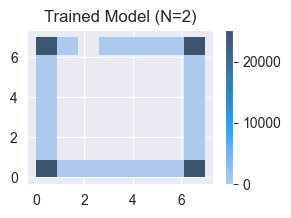

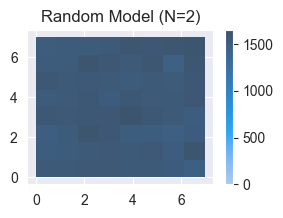

In [16]:
import matplotlib.pyplot as plt

def plot_small_hist2d(model, d_output, n_test_samples=500, label=None):
    output = model.generate(torch.ones(n_test_samples, 1))
    y = output.y.numpy()
    plt.figure(figsize=(3, 2))
    hist = sns.histplot(x=y[:,0], y=y[:,1], bins=[d_output, d_output], cbar=True)
    if label is not None:
        plt.title(label)
    plt.show()
    
plot_small_hist2d(model, d_output, n_test_samples=100_000, label='Trained Model (N=2)')
plot_small_hist2d(model_rand, d_output, n_test_samples=100_000, label='Random Model (N=2)')

### HMM

In [ ]:
!pip install hmmlearn

In [99]:
import numpy as np
from hmmlearn.hmm import CategoricalHMM

seq_len = 2
n_features = 8

# Two simple sequences
seq1 = np.zeros((seq_len, 1), dtype=int)  # 0 0 0 0 0 0
seq2 = np.ones((seq_len, 1), dtype=int)   # 1 1 1 1 1 1

# Concatenate them
X = np.concatenate([seq1, seq2])
lengths = [len(seq1), len(seq2)]    # [6, 6]

# Define and fit HMM
model = CategoricalHMM(n_components=2, n_features=n_features)
model.fit(X, lengths)

# Inspect
print("Start probabilities:\n", model.startprob_)
print("Transition matrix:\n", model.transmat_)
print("Emission probabilities:\n", model.emissionprob_)

# Predict hidden states for each sequence
states = model.predict(X, lengths)
print("States per seq:")
print("seq1:", states[:len(seq1)])
print("seq2:", states[len(seq1):])

# Sample new data
X_gen, Z_gen = model.sample(seq_len)
print("Generated observations:", X_gen.ravel())

# # Make random
# model.transmat_ = torch.from_numpy(np.random.randn(2, 2)).softmax(dim=1).numpy()
# model.emissionprob_ = torch.from_numpy(np.random.randn(2, 8)).softmax(dim=1).numpy()


Fitting a model with 17 free scalar parameters with only 4 data points will result in a degenerate solution.


Start probabilities:
 [0.81178615 0.18821385]
Transition matrix:
 [[0.00360251 0.99639749]
 [0.66315427 0.33684573]]
Emission probabilities:
 [[0.50016484 0.49983516 0.         0.         0.         0.
  0.         0.        ]
 [0.49985396 0.50014604 0.         0.         0.         0.
  0.         0.        ]]
States per seq:
seq1: [0 1]
seq2: [0 1]
Generated observations: [1 1]


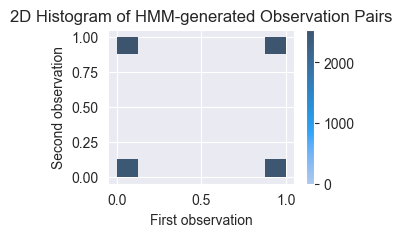

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

n_test_samples = 10_000
xs = []
for i in range(n_test_samples):
    X_gen, Z_gen = model.sample(seq_len)
    xs.append(X_gen.ravel())

xs = np.array(xs)

plt.figure(figsize=(3, 2))
hist = sns.histplot(x=xs[:,0], y=xs[:,1], bins=[n_features, n_features], cbar=True)
plt.xlabel("First observation")
plt.ylabel("Second observation")
plt.title("2D Histogram of HMM-generated Observation Pairs")
plt.show()